### Import Libraries

In [8]:
# Librerie per lettura file
import pandas as pd
from pathlib import Path
import json
import os
import psutil
import numpy as np
from tqdm import tqdm
import warnings
import pickle
import joblib

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
)




#Kfold and GridSearch

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV



# Grafici
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Data Analysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputRegressor

# Modelli con Alberi
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from lightgbm import LGBMClassifier, LGBMRegressor


# Librerie Torch per MLP
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
from torchmetrics import F1Score, Accuracy, Precision, Recall
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# Explainable AI (SHAP)
import shap

# Librerie per gestione dati parallela
import modin.pandas as mpd
import modin.config as cfg

# Visualizzazione matrice di confusione
from sklearn.metrics import ConfusionMatrixDisplay

import shap
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


In this section, we will test the models on patient data, categorizing them as Responders (including both Partial Responders and Responders) and Non-Responders.
We will evaluate the models using three different approaches described in the article.

## Reading and Preprocessing

In [9]:
df_clean = pd.read_csv("Preprocessing/transcrittoma_pulito.csv")
score_df = pd.read_csv("Preprocessing/drug_scores_with_targets.csv")
score_df.head(31)

,Drug,Score,Drug_name,Targets
0,1248.0,NaN,FK866,['NAMPT']
1,290.0,0.179823,KIN001-260,['IKK-complex']
2,306.0,0.168887,TG101348,['JAK2']
3,222.0,0.162292,BX-912,['PDPK1']
4,329.0,0.161085,QL-XI-92,['DDR1']
5,265.0,0.151817,Tubastatin A,['HDAC6']
6,326.0,0.142042,GSK690693,['AKT']
7,253.0,0.140113,XMD14-99,"['CAMK1', 'EPHB3']"
8,257.0,0.137881,NPK76-II-72-1,['PLK3']
9,309.0,0.136929,Y-39983,"['ROCK2', 'ROCK1']"


In [11]:
df_drug = df_clean[df_clean['Drug_id']==1008.0]

df_paz = pd.read_csv("pazienti_Meth/trans_zscore1_47.csv")

df_paz.head()

,Unnamed: 0,Sample,Responder,AR,ASCL1,ATF1,ATF5,ATF6,CTNNB1,DDIT3,...,YAP1,ZBTB16,ZBTB7A,ZEB2,ZFP42,ZIC1,ZNF143,ZNF148,ZNF382,ZNF91
0,1,JIA1,1,1.894272,-0.309378,1.035928,0.886898,0.511171,-0.789433,0.707940,...,-0.946272,0.515685,0.598570,0.311221,-1.203843,0.411460,0.378909,0.959505,-0.930626,-0.458127
1,2,JIA2,0,2.043634,-0.480482,1.716803,0.916012,0.653192,-1.146481,2.175817,...,-1.079150,0.341859,0.894588,-0.030062,-1.153091,1.065015,1.812554,0.824140,-1.222344,-0.371628
2,3,JIA3,1,2.382808,-2.595033,1.629774,1.282168,0.804878,-1.000305,2.153548,...,-1.244689,0.619060,0.716275,0.040962,-1.383418,0.332573,1.776411,1.363157,-0.913563,-0.253214
3,4,JIA4,0,1.808623,-0.459787,1.378263,0.670063,0.747484,-1.087729,0.981295,...,-1.017271,0.535317,0.527313,0.226297,-1.387354,0.487284,1.955461,0.824436,-1.372911,-0.439739
4,5,JIA5,1,1.481328,-0.368326,1.150023,1.264537,0.489271,-0.733424,0.707565,...,-0.975982,0.484888,0.523467,0.252156,-1.398450,0.380689,0.337234,0.931327,-1.040472,-0.345597


In [13]:
labels = df_paz['Responder']
df_paz['Sensitivity'] = df_paz['Responder']

#df_paz['Sensitivity'] = df_paz['Response_Fedratinib']
df_paz = df_paz.drop(columns=['Unnamed: 0','Responder'])
df_paz['Drug_Target'] = 44
df_paz['Target_clean'] = 40

In [14]:
cols_to_check = df_clean.iloc[:, 9:].columns

missing_cols = [col for col in cols_to_check if col not in df_paz.columns]

print(len(missing_cols))



for col in missing_cols:
    mean_val = df_clean[col].mean()
    df_paz[col] = mean_val

df_paz['cell_name']=df_paz['Sample']
cols_to_drop = [col for col in df_paz.columns if col not in df_clean.columns]
df_paz.drop(columns=cols_to_drop, inplace=True)

common_cols = [col for col in df_clean.columns if col in df_paz.columns]
df_paz = df_paz[common_cols]

df_paz.head()

61


,cell_name,Sensitivity,Target_clean,Drug_Target,AP1,AR,ATF6,ATOH1,CEBPB,CEBPD,...,ZEB1,ZEB2,ZFP42,ZFPM1,ZFPM2,ZIC1,ZNF148,ZNF382,ZNF384,ZNF91
0,JIA1,1,40,44,1.743057,1.894272,0.511171,-2.224042,1.481410,-0.604927,...,0.432786,0.311221,-1.203843,1.021287,-0.784858,0.411460,0.959505,-0.930626,-3.313114,-0.458127
1,JIA2,0,40,44,2.334713,2.043634,0.653192,-2.224042,1.687575,-0.871776,...,0.646275,-0.030062,-1.153091,1.886731,-0.784858,1.065015,0.824140,-1.222344,-2.741063,-0.371628
2,JIA3,1,40,44,2.587080,2.382808,0.804878,-2.224042,2.309372,-0.422633,...,2.534282,0.040962,-1.383418,0.955666,-0.784858,0.332573,1.363157,-0.913563,-2.514459,-0.253214
3,JIA4,0,40,44,1.304111,1.808623,0.747484,-2.224042,1.536157,-1.252470,...,0.378236,0.226297,-1.387354,0.778462,-0.784858,0.487284,0.824436,-1.372911,-2.463321,-0.439739
4,JIA5,1,40,44,1.544322,1.481328,0.489271,-2.224042,1.384135,-1.134745,...,0.431012,0.252156,-1.398450,0.701745,-0.784858,0.380689,0.931327,-1.040472,-2.568711,-0.345597


In [15]:
df_nan_sens = df_clean[df_clean["Sensitivity"].isna()]  
df_clean = df_clean[df_clean["Sensitivity"].notna()] 

## Test

### Test Sensitivity

#### Modelli ad albero

In [16]:
def evaluate_model_directory(model_dir, df, labels, drug_name="TG101348", best_threshold = 0.4):
  
    """
    Evaluate an ensemble of trained models stored in the specified directory.
    
    This function:
    - Loads 5 trained models and their AUC_PR scores as weights.
    - Encodes categorical features and prepares the dataset for prediction.
    - Computes weighted predicted probabilities and binary predictions based on the threshold already calculated
    - Plots the confusion matrix and precision-recall vs. threshold curves.
    - Calculates and prints performance metrics (ROC AUC, AUC PR, F1 score).
    - Ranks samples by predicted probability and returns a sorted DataFrame.
    - Generates SHAP explanations for individual predictions, saving waterfall and bar plots.
    
    Parameters:
    - model_dir (str): Directory containing trained models.
    - df (pd.DataFrame): Input data with features and true labels.
    - labels (list): Response Fedratinib.
    - drug_name (str): Prefix used in model filenames (default: "TG101348").
    - best_threshold (float): Probability cutoff to classify samples (default: 0.4).
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame sorted by predicted probability with original labels.
    """

    shap_dir = f"{model_dir}_SHAP_Meth"
    os.makedirs(shap_dir, exist_ok=True)

    individual_dir = os.path.join(shap_dir, "individuals")
    os.makedirs(individual_dir, exist_ok=True)

    # Model
    models = []
    for fold in range(5):
        path = f"{model_dir}/{drug_name}_models/model_fold_{fold}.pkl"
        model_info = joblib.load(path)
        models.append(model_info)

    new_df = df.copy()
    le_cell = LabelEncoder()
    new_df['cell_name'] = le_cell.fit_transform(new_df['cell_name'].astype(str))
    X_new = new_df.drop(columns=["Sensitivity"])

    # Predict Probabilities and Sensitivities
    weights = np.array([m["auc_pr"] for m in models])
    weights = weights / weights.sum()
    y_pred_prob = sum(weights[i] * models[i]["model"].predict_proba(X_new)[:, 1] for i in range(len(models)))
    y_pred = (y_pred_prob > best_threshold).astype(int)
    
    # Cutoff
    cutoff_range = np.arange(y_pred_prob.min(), y_pred_prob.max(), 0.01)
    precisions_cutoff = []
    recalls_cutoff = []
    true_labels = np.array(new_df["Sensitivity"])
    for cutoff in cutoff_range:
        predicted_labels = (y_pred_prob > cutoff).astype(int)
        precisions_cutoff.append(precision_score(true_labels, predicted_labels, zero_division=0))
        recalls_cutoff.append(recall_score(true_labels, predicted_labels, zero_division=0))
        

    probabilities = np.array(y_pred_prob)
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probabilities = probabilities[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Print results
    print(f"\nEvaluation for {model_dir}")
    print(f"ROC AUC: {roc_auc_score(true_labels, y_pred_prob):.3f}")
    print(f"AUC PR: {average_precision_score(true_labels, y_pred_prob):.3f}")
    print(f"F1 Score: {f1_score(true_labels, y_pred):.3f}")

    # COnfusion Matrix
    cm = confusion_matrix(true_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix @ Best Threshold ({best_threshold:.2f})")
    plt.grid(False)
    plt.show()
    
    # PR
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.title(f'Precision-Recall vs Threshold: {model_dir.split("/")[-1]}')
    plt.xlabel("Probability Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Dictionary
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Sorted Probabilities': sorted_probabilities,
        'Original Label': sorted_labels
    })

    print(df_sorted)


    # SHAP
    explainer = shap.TreeExplainer(models[0]["model"], feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_new)

    expected_value = explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = expected_value[1] if len(expected_value) > 1 else expected_value[0]

    ## SHAP for individual patients
    for i in range(X_new.shape[0]):
        plt.figure()

        if isinstance(shap_values, list):
            shap_value = shap_values[1][i]
        else:
            shap_value = shap_values[i] 

        if model_dir == "Results/Models_Sensitivity/RF":
            shap_value = shap_values[i, :, 1] 

        shap_series = pd.Series(shap_value, index=X_new.columns)
        top5_neg = shap_series.sort_values().head(5)
        top5_pos = shap_series.sort_values(ascending=False).head(5)
        combined = pd.concat([top5_neg, top5_pos])
        colors = ['skyblue'] * 5 + ['lightcoral'] * 5

        # Waterfall plot
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_value,
                base_values=expected_value,
                data=X_new.iloc[i],
                feature_names=X_new.columns.tolist()
            ),
            max_display=10,
            show=False
        )
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_example_{i}.png")
        plt.close()


        # Shap top 5
        plt.figure(figsize=(6, 4))
        plt.barh(combined.index[::-1], combined.values[::-1], color=colors[::-1])
        plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
        plt.title(f"Top 5 ± SHAP - {i}", fontsize=12)
        plt.xlabel("SHAP Value (Effect)")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_top5_{i}.png", format="png", dpi=300)
        plt.close()



    return df_sorted


#### model_sensitivity

Results/Models_Sensitivity/XGB

Evaluation for Results/Models_Sensitivity/XGB
ROC AUC: 0.621
AUC PR: 0.699
F1 Score: 0.788


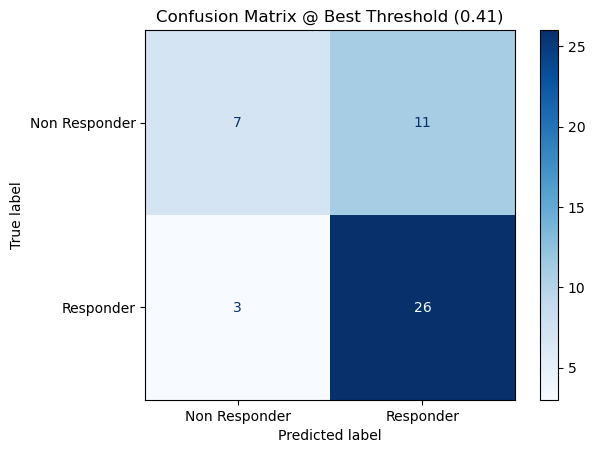

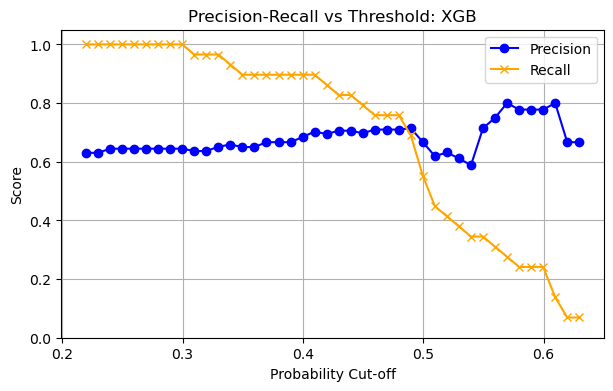

    Original Index  Sorted Probabilities  Original Label
0                3              0.637139               0
1               27              0.635061               1
2               24              0.634019               1
3               30              0.614520               1
4               12              0.611593               1
5                4              0.608678               1
6               45              0.604860               1
7               16              0.602871               0
8                8              0.602487               1
9                6              0.570527               1
10              41              0.565297               0
11              33              0.562739               1
12              40              0.553380               0
13              29              0.550308               1
14              46              0.546844               0
15               7              0.545009               0
16              23             

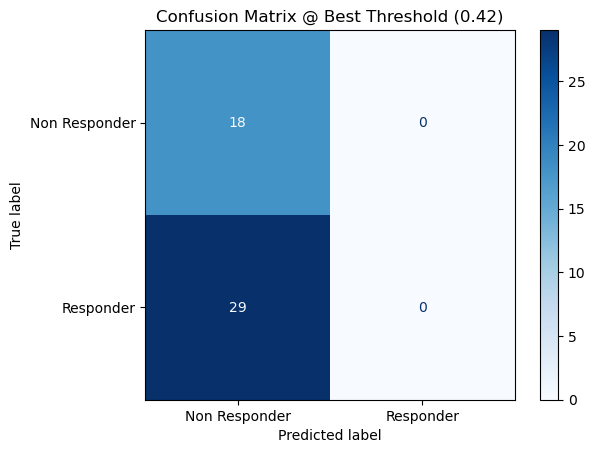

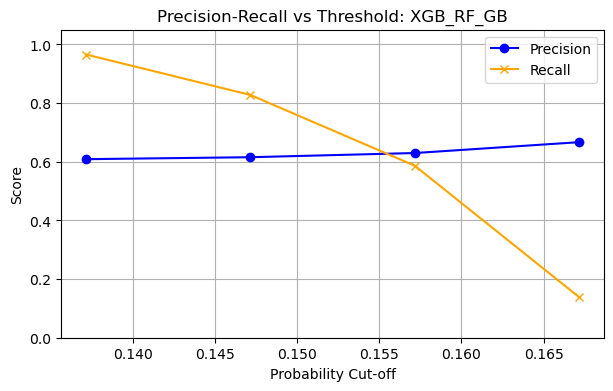

    Original Index  Sorted Probabilities  Original Label
0               16              0.175600               0
1               45              0.173346               1
2                3              0.168423               0
3               24              0.167944               1
4               29              0.167429               1
5               13              0.167368               1
6               18              0.167092               0
7               23              0.166599               0
8               33              0.166022               1
9               22              0.165542               0
10               8              0.164831               1
11               5              0.164376               1
12              20              0.164335               1
13              42              0.164268               1
14              27              0.163489               1
15               1              0.163190               0
16              15             

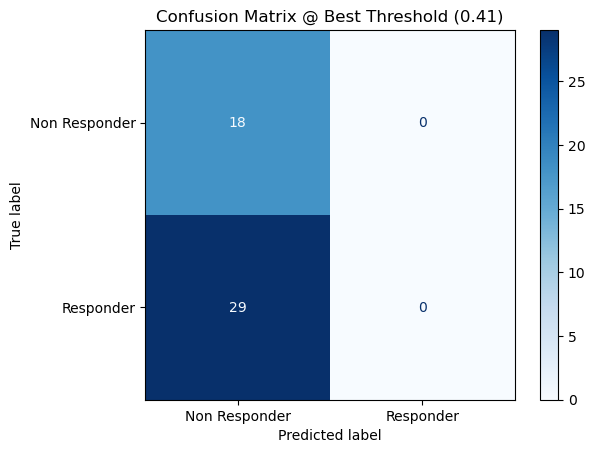

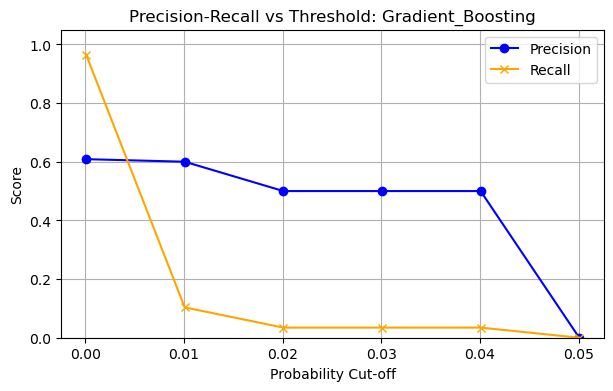

    Original Index  Sorted Probabilities  Original Label
0               17              0.057545               0
1               29              0.049897               1
2               24              0.017665               1
3               28              0.012443               1
4               22              0.012140               0
5               25              0.010000               1
6               43              0.009776               1
7                8              0.009541               1
8               37              0.009019               0
9               12              0.008362               1
10              26              0.008242               0
11               2              0.007952               1
12               3              0.007640               0
13              13              0.007001               1
14              10              0.006210               1
15              19              0.005960               0
16              27             

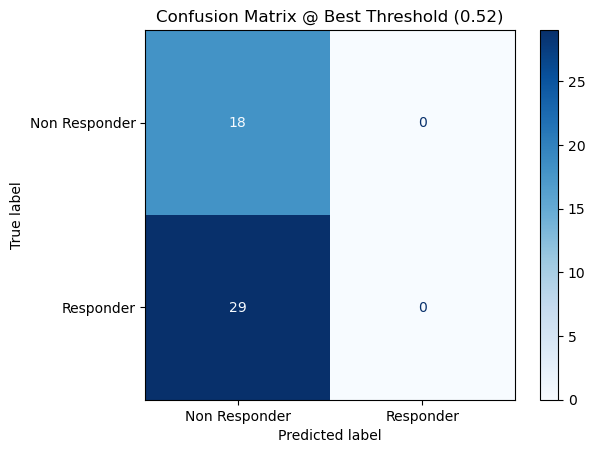

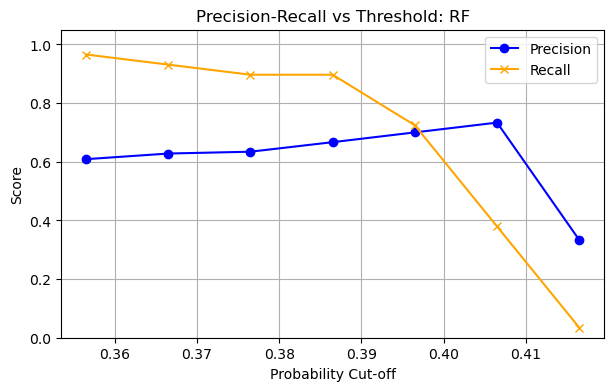

    Original Index  Sorted Probabilities  Original Label
0               38              0.423636               0
1               16              0.419533               0
2               43              0.418107               1
3                0              0.416049               1
4               36              0.414816               1
5                9              0.412950               1
6               20              0.411648               1
7               29              0.410177               1
8               40              0.409835               0
9               31              0.408841               1
10               6              0.408110               1
11               8              0.407882               1
12              27              0.407821               1
13              18              0.407074               0
14              42              0.406910               1
15              10              0.406011               1
16              45             

In [17]:
# Directories
drug_models_dirs = [
    "Results/Models_Sensitivity/XGB",
    "Results/Models_Sensitivity/XGB_RF_GB",
    "Results/Models_Sensitivity/Gradient_Boosting",
    "Results/Models_Sensitivity/RF",
]

#RUn the function with the threshold calculaated on the cell lines
df_sorted_list = []
best_threshold = [0.411,0.425, 0.412,0.516]
for i in range(len(best_threshold)):
    model_dir = drug_models_dirs[i]
    print(model_dir)
    bt = best_threshold[i]
    df_sorted = evaluate_model_directory(model_dir, df_paz, labels,best_threshold=bt)
    df_sorted_list.append(df_sorted)

#### Rete neurale

In [18]:
def evaluate_neural_ensemble(model_dir, df, top_features_path, label_col="Sensitivity", drug_name="Drug", best_threshold = 0.5):

    """
    Evaluate an ensemble of trained neural network models on a classification task.
    
    This function:
    - Loads top-ranked input features and uses them to prepare the dataset.
    - Loads multiple neural network models trained on different folds.
    - Predicts class probabilities using a weighted ensemble (based on models' AUC PR).
    - Generates binary predictions using a specified threshold.
    - Computes and displays evaluation metrics: ROC AUC, AUC PR, F1 score.
    - Plots confusion matrix and precision-recall vs. threshold curves.
    - Sorts samples by predicted probability and returns them in a DataFrame.
    
    Parameters:
    - model_dir (str): Directory containing trained neural network models.
    - df (pd.DataFrame): Dataset with features and target labels.
    - top_features_path (str): Path to CSV file containing top-ranked feature names.
    - label_col (str): Name of the column with true binary labels (default: "Sensitivity").
    - drug_name (str): Name of the drug or model label for plot titles (default: "Drug").
    - best_threshold (float): Probability cutoff for classification (default: 0.5).
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame with sample indices, sorted predicted probabilities, and original labels.
    """

    best_features = pd.read_csv(top_features_path, index_col=0)
    top_features = best_features.index.tolist()

    # Models
    n_folds = 5
    models = []
    for fold in range(n_folds):
        model_path = f"{model_dir}/model_fold_{fold}.pkl"
        model_info = joblib.load(model_path)
        models.append(model_info)

    X = df[top_features].copy()
    y = df[label_col].values
    X_input = np.array(X).astype(np.float32)
    X_input = X_input.reshape((X_input.shape[0], X_input.shape[1], 1))  

    #Predict probabilities and sensitivities  
    weights = np.array([m["auc_pr"] for m in models])
    weights /= weights.sum()
    y_pred_prob = sum(
        weights[i] * models[i]["model"].predict(X_input)[:, 0]
        for i in range(n_folds)
    )
    y_pred = (y_pred_prob > best_threshold).astype(int)

    # Cutoff
    cutoff_range = np.arange(y_pred_prob.min(), y_pred_prob.max(), 0.01)
    precisions_cutoff, recalls_cutoff = [], []
    for cutoff in cutoff_range:
        preds = (y_pred_prob > cutoff).astype(int)
        precisions_cutoff.append(precision_score(y, preds, zero_division=0))
        recalls_cutoff.append(recall_score(y, preds, zero_division=0))

    probabilities = np.array(y_pred_prob)
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probabilities = probabilities[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Print results
    print(f"\n Evaluation - {drug_name}")
    print(f"ROC AUC: {roc_auc_score(y, y_pred_prob):.3f}")
    print(f"AUC PR: {average_precision_score(y, y_pred_prob):.3f}")
    print(f"F1 Score: {f1_score(y, y_pred):.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix @ Best Threshold ({best_threshold:.2f})")
    plt.grid(False)
    plt.show()

    # PR
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.xlabel("Probability Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(f"Precision & Recall vs Threshold - {drug_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Dictionary
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Sorted Probabilities': sorted_probabilities,
        'Original Label': sorted_labels
    })

    print(df_sorted)

    return df_sorted


##### cnn

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2bce339c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

 Evaluation - TG101348
ROC AUC: 0.556
AUC PR: 0.651


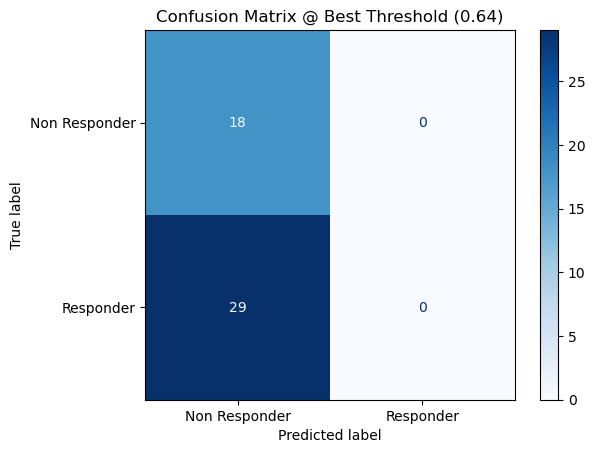

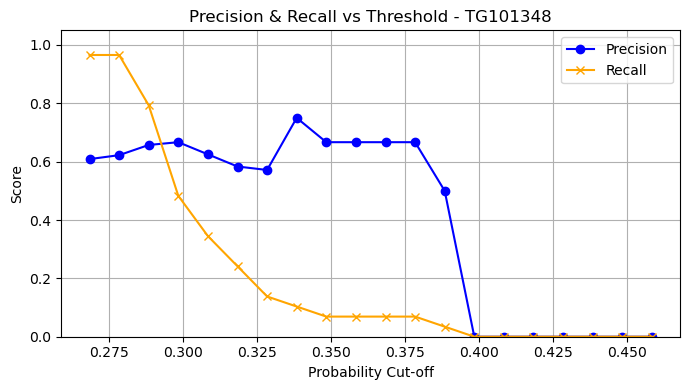

    Original Index  Sorted Probabilities  Original Label
0               46              0.466143               0
1               36              0.392108               1
2               20              0.384864               1
3               27              0.342869               1
4               43              0.338041               1
5               16              0.336278               0
6                1              0.329248               0
7               10              0.327333               1
8                7              0.325588               0
9               40              0.325087               0
10              34              0.322900               1
11               8              0.321913               1
12              32              0.317027               1
13              28              0.312166               1
14               9              0.310859               1
15              38              0.310109               0
16              33             

In [19]:
df_sorted_cnn = evaluate_neural_ensemble(
    model_dir="Results/Models_Sensitivity/cnn_Sensitivity/TG101348_models",
    df=df_paz,
    top_features_path="Results/Models_Sensitivity/RF/TG101348/top20_features.csv",
    label_col="Sensitivity",
    drug_name="TG101348",
    best_threshold = 0.636
)


##### MLP

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

 Evaluation - TG101348
ROC AUC: 0.582
AUC PR: 0.637
F1 Score: 0.000


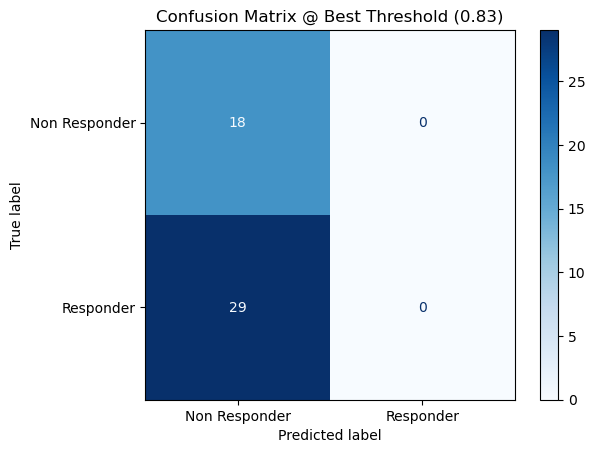

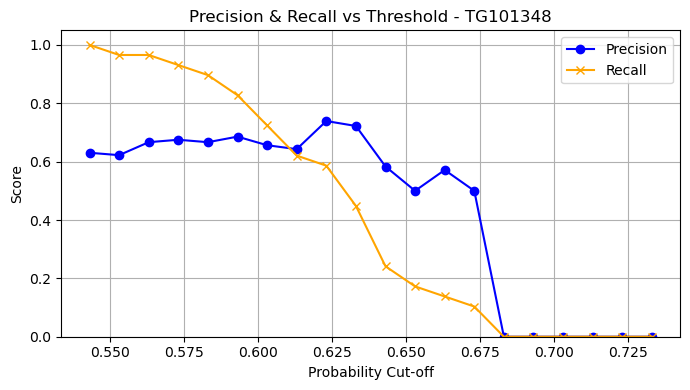

    Original Index  Sorted Probabilities  Original Label
0               16              0.739056               0
1               46              0.697204               0
2                7              0.681789               0
3               43              0.678904               1
4               36              0.677009               1
5                9              0.676981               1
6               27              0.666167               1
7               28              0.662440               1
8                3              0.656337               0
9               40              0.653624               0
10              31              0.646298               1
11              42              0.645737               1
12              11              0.637997               1
13              24              0.637619               1
14              10              0.637012               1
15              13              0.633982               1
16               8             

In [20]:
df_sorted_cnn = evaluate_neural_ensemble(
    model_dir="Results/Models_Sensitivity/mlp_Sensitivity/TG101348_models",
    df=df_paz,
    top_features_path="Results/Models_Sensitivity/RF/TG101348/top20_features.csv",
    label_col="Sensitivity",
    drug_name="TG101348",
    best_threshold=0.832
)


### Test IC50

#### Modelli ad albero

In [21]:
def evaluate_model_directory_ic50(model_dir, df_test, labels, drug_name="TG101348", cutoff = 0.5):

    """
    Evaluate an ensemble of trained models stored in the specified directory.
    
    This function:
    - Loads 5 trained models and their AUC_PR scores as weights.
    - Encodes categorical features and prepares the dataset for prediction.
    - Predict IC50 and sensitivity predictions based on the threshold already calculated
    - Plots the confusion matrix and precision-recall vs. threshold curves.
    - Calculates and prints performance metrics (ROC AUC, AUC PR, F1 score).
    - Ranks samples by predicted probability and returns a sorted DataFrame.
    - Generates SHAP explanations for individual predictions, saving waterfall and bar plots.
    
    Parameters:
    - model_dir (str): Directory containing trained models.
    - df_test (pd.DataFrame): Input data with features and true labels.
    - labels (list): Response Fedratinib.
    - drug_name (str): Prefix used in model filenames (default: "TG101348").
    - best_threshold (float): Probability cutoff to classify samples (default: 0.5).
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame sorted by predicted IC50 with original labels.
    """


    #models
    models = []
    for fold in range(5):
        path = f"{model_dir}/{drug_name}_models/model_fold_{fold}.pkl"
        model_info = joblib.load(path)
        models.append(model_info)

    new_df = df_test.copy()
    le_cell = LabelEncoder()
    new_df['cell_name'] = le_cell.fit_transform(new_df['cell_name'].astype(str))
    X_new = new_df.drop(columns=["Sensitivity",'cell_name'])

    #Predict Ic50 and sensitivityies
    y_pred_ic50 = np.mean([m.predict(X_new) for m in models], axis=0)
    y_pred_sens = (y_pred_ic50 < cutoff).astype(int)
    true_labels = np.array(new_df["Sensitivity"])

    # Cutoff
    cutoff_range = np.arange(y_pred_ic50.min(), y_pred_ic50.max(), 0.1)
    precisions_cutoff = []
    recalls_cutoff = []

    for c in cutoff_range:
        predicted_sens = (y_pred_ic50 < c).astype(int)
        precisions_cutoff.append(precision_score(true_labels, predicted_sens, zero_division=0))
        recalls_cutoff.append(recall_score(true_labels, predicted_sens, zero_division=0))

    # COnfusion Matrix
    cm = confusion_matrix(true_labels, y_pred_sens)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix @ IC50 Cutoff (percentile {cutoff})")
    plt.grid(False)
    plt.show()

    # Pr
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.title(f'Precision-Recall vs Predicted IC50 Cutoff: {model_dir.split("/")[-1]}')
    plt.xlabel("IC50 Predicted Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    #Print Results
    print(f"\nEvaluation for {model_dir}")
    print(f"F1 Score: {f1_score(true_labels, y_pred_sens):.3f}")
    print(f"Precision: {precision_score(true_labels, y_pred_sens, zero_division=0):.3f}")
    print(f"Recall: {recall_score(true_labels, y_pred_sens, zero_division=0):.3f}")

    #Dictionary
    sorted_indices = np.argsort(y_pred_ic50)
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Predicted IC50': y_pred_ic50[sorted_indices],
        'True Sensitivity': np.array(labels)[sorted_indices]
    })

    print(df_sorted)

    # SHAP directory
    shap_dir = f"{model_dir}_SHAP_Meth"
    os.makedirs(shap_dir, exist_ok=True)
    individual_dir = os.path.join(shap_dir, "individuals")
    os.makedirs(individual_dir, exist_ok=True)

   #Shap values
    explainer = shap.TreeExplainer(models[0])
    shap_values = -explainer.shap_values(X_new)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    expected_value = explainer.expected_value
    if isinstance(expected_value, list) or isinstance(expected_value, np.ndarray):
        expected_value = expected_value[0]

    # SHAP for each drug
    N = 15  
    for i in range(min(N, X_new.shape[0])):
        
        # Waterfall plot
        plt.figure()
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values[i],
                base_values=expected_value,
                data=X_new.iloc[i],
                feature_names=X_new.columns.tolist()
            ),
            max_display=10,
            show=False
        )
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_example_{i}.png")
        plt.close()


        shap_series = pd.Series(shap_values[i], index=X_new.columns)
        top5_neg = shap_series.sort_values().head(5)
        top5_pos = shap_series.sort_values(ascending=False).head(5)
        combined = pd.concat([top5_neg, top5_pos])
        colors = ['skyblue'] * 5 + ['lightcoral'] * 5


        # Shap top 5
        plt.figure(figsize=(6, 4))
        plt.barh(combined.index[::-1], combined.values[::-1], color=colors[::-1])
        plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
        plt.title(f"Top 5 ± SHAP - {i}", fontsize=12)
        plt.xlabel("SHAP Value (Effect)")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_top5_{i}.png", format="png", dpi=300)
        plt.close()

    # Shap sumaary plot
    shap.summary_plot(shap_values, X_new, feature_names=X_new.columns, plot_type="bar", show=False)
    plt.title(f"SHAP Bar Plot - {model_dir.split('/')[-1]}")
    plt.tight_layout()
    plt.savefig(f"{shap_dir}/shap_bar_plot.png")
    plt.close()

    return df_sorted

### Neural Network models

In [22]:
def evaluate_neural_ensemble_ic50(model_dir, df, top_features_path, label_col="IC50", drug_name="Drug",cutoff = 0.5):
    """
    Evaluate an ensemble of trained neural networks on IC50 prediction (regression task).
    
    Parameters:
    - model_dir (str): Directory containing trained neural network models.
    - df (pd.DataFrame): Dataset with features and target labels.
    - top_features_path (str): Path to CSV file containing top-ranked feature names.
    - label_col (str): Name of the column with true IC50 values (default: "IC50").
    - drug_name (str): Name of the drug or model label for plot titles.
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame with sample indices, predicted IC50, and true IC50, sorted by prediction.
    """


    # Load top features
    best_features = pd.read_csv(top_features_path, index_col=0)
    top_features = best_features.index.tolist()

    # Load models
    n_folds = 5
    models = []
    for fold in range(n_folds):
        model_path = f"{model_dir}/model_fold_{fold}.pkl"
        model_info = joblib.load(model_path)
        models.append(model_info)

    # Prepare data
    X = df[top_features].copy()
    y_true = df[label_col].values
    X_input = np.array(X).astype(np.float32)
    X_input = X_input.reshape((X_input.shape[0], X_input.shape[1], 1))

    # Carica i modelli
    models = []
    for fold in range(n_folds):
        model_path = f"{model_dir}/model_fold_{fold}.pkl"
        model = joblib.load(model_path)
        models.append(model)

    # Predizioni
    predictions = np.array([
        model.predict(X_input)[:, 0]
        for model in models
    ])

    # Media semplice sulle predizioni
    y_pred_ic50 = np.mean(predictions, axis=0)
    y_pred_sens = (y_pred_ic50 < cutoff).astype(int)
    true_labels = np.array(df["Sensitivity"])

    # Cutoff
    cutoff_range = np.arange(y_pred_ic50.min(), y_pred_ic50.max(), 0.1)
    precisions_cutoff = []
    recalls_cutoff = []

    for c in cutoff_range:
        predicted_sens = (y_pred_ic50 < c).astype(int)
        precisions_cutoff.append(precision_score(true_labels, predicted_sens, zero_division=0))
        recalls_cutoff.append(recall_score(true_labels, predicted_sens, zero_division=0))

    # COnfusion Matrix
    cm = confusion_matrix(true_labels, y_pred_sens)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix @ IC50 Cutoff (percentile {cutoff})")
    plt.grid(False)
    plt.show()

    # Pr
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.title(f'Precision-Recall vs Predicted IC50 Cutoff: {model_dir.split("/")[-1]}')
    plt.xlabel("IC50 Predicted Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    #Print Results
    print(f"\nEvaluation for {model_dir}")
    print(f"F1 Score: {f1_score(true_labels, y_pred_sens):.3f}")
    print(f"Precision: {precision_score(true_labels, y_pred_sens, zero_division=0):.3f}")
    print(f"Recall: {recall_score(true_labels, y_pred_sens, zero_division=0):.3f}")

    #Dictionary
    sorted_indices = np.argsort(y_pred_ic50)
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Predicted IC50': y_pred_ic50[sorted_indices],
        'True Sensitivity': np.array(labels)[sorted_indices]
    })

    print(df_sorted)


    return df_sorted


##### NO SMOTE

#### tree models

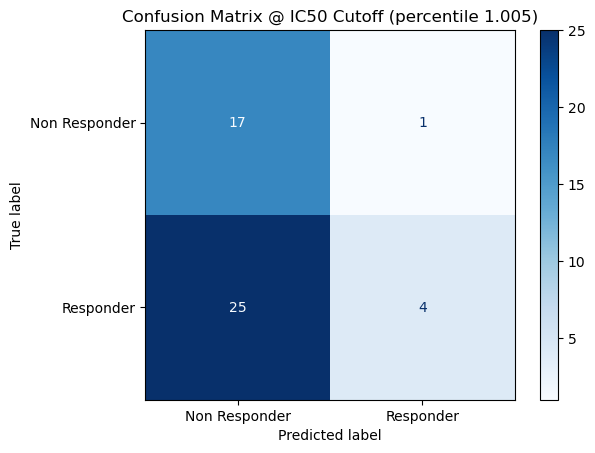

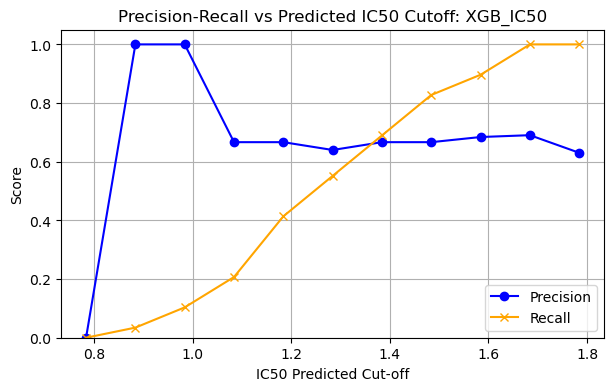


Evaluation for Results/Models_IC50/XGB_IC50
F1 Score: 0.235
Precision: 0.800
Recall: 0.138
    Original Index  Predicted IC50  True Sensitivity
0               10        0.784023                 1
1               34        0.885069                 1
2               28        0.951344                 1
3               38        0.996249                 0
4               43        1.000654                 1
5               45        1.036505                 1
6               31        1.037464                 1
7               40        1.054209                 0
8                7        1.061649                 0
9               25        1.086581                 1
10              15        1.101881                 1
11              11        1.108275                 1
12              14        1.118693                 1
13              41        1.167257                 0
14              16        1.168898                 0
15              42        1.169932                 1
16     

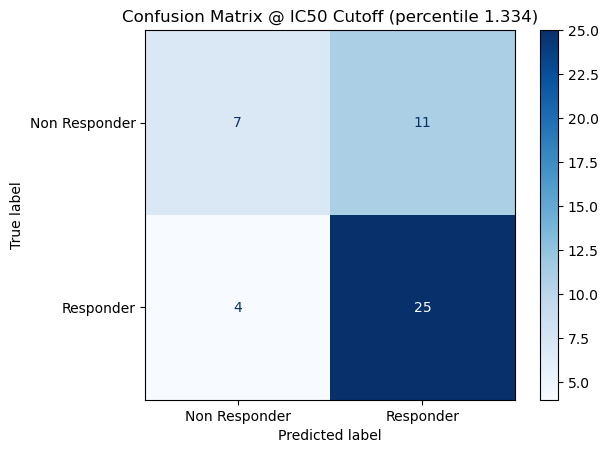

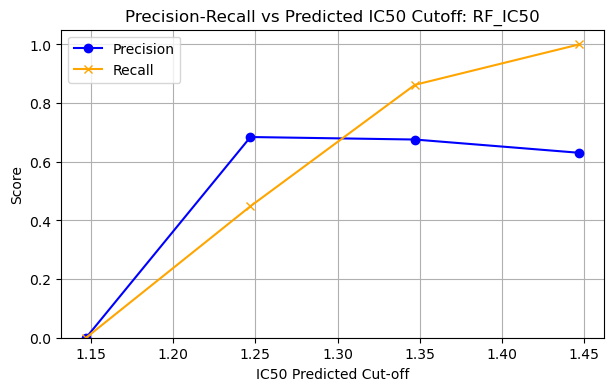


Evaluation for Results/Models_IC50/RF_IC50
F1 Score: 0.769
Precision: 0.694
Recall: 0.862
    Original Index  Predicted IC50  True Sensitivity
0               25        1.146981                 1
1               38        1.163817                 0
2               36        1.165562                 1
3               40        1.173274                 0
4               23        1.179478                 0
5               34        1.181755                 1
6                7        1.189650                 0
7               12        1.191815                 1
8               16        1.193915                 0
9               10        1.194533                 1
10               0        1.200875                 1
11              31        1.200939                 1
12              44        1.211408                 0
13              45        1.212823                 1
14              43        1.225316                 1
15              32        1.228717                 1
16      

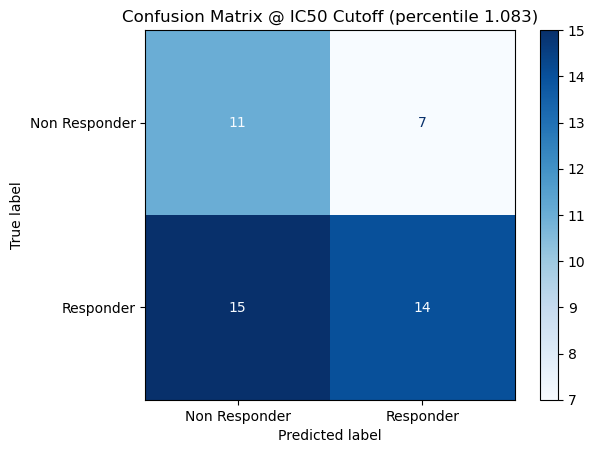

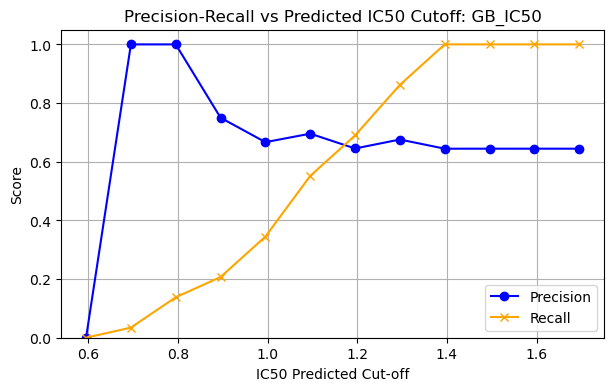


Evaluation for Results/Models_IC50/GB_IC50
F1 Score: 0.560
Precision: 0.667
Recall: 0.483
    Original Index  Predicted IC50  True Sensitivity
0               11        0.595010                 1
1               20        0.731013                 1
2                0        0.735682                 1
3               15        0.770181                 1
4               44        0.840735                 0
5               29        0.847454                 1
6               21        0.887365                 0
7               31        0.888738                 1
8               40        0.907707                 0
9               38        0.910381                 0
10              13        0.918421                 1
11              43        0.948579                 1
12              32        0.952651                 1
13              34        0.963969                 1
14              37        0.994334                 0
15              10        1.014490                 1
16      

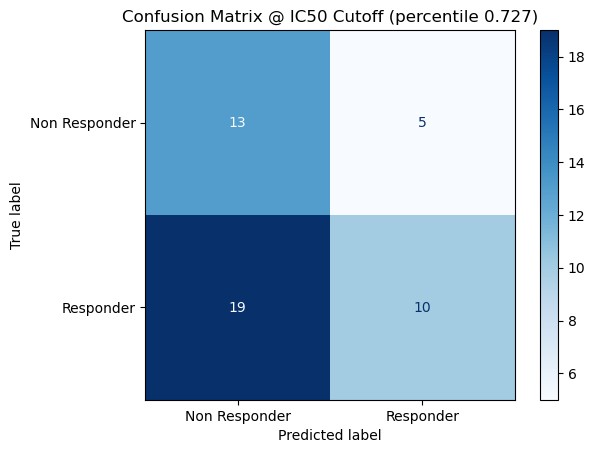

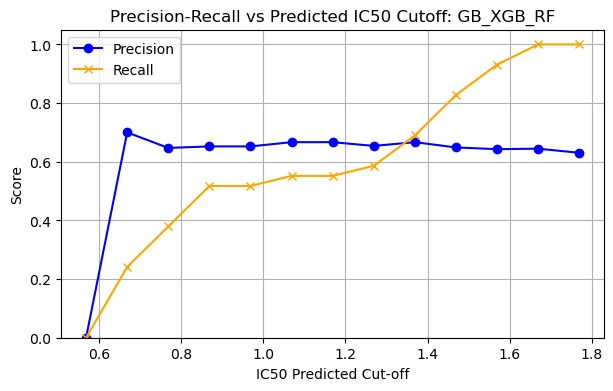


Evaluation for Results/Models_IC50/GB_XGB_RF
F1 Score: 0.455
Precision: 0.667
Recall: 0.345
    Original Index  Predicted IC50  True Sensitivity
0               43        0.569049                 1
1               40        0.582277                 0
2               19        0.602012                 0
3                0        0.609586                 1
4               11        0.613720                 1
5               42        0.619328                 1
6               31        0.629884                 1
7               10        0.634201                 1
8               20        0.648358                 1
9               38        0.651342                 0
10              23        0.692027                 0
11               4        0.707926                 1
12              12        0.709084                 1
13              33        0.710266                 1
14              21        0.712737                 0
15              37        0.731937                 0
16    

In [23]:
drug_models_dirs = [
    "Results/Models_IC50/XGB_IC50",
    "Results/Models_IC50/RF_IC50",
    "Results/Models_IC50/GB_IC50",
    "Results/Models_IC50/GB_XGB_RF"
]

cut = [1.005,1.334,1.083,0.727] # prese dal grafico 
df_sorted_list = []

for i in range(len(drug_models_dirs)):
    model_dir, cutoff = drug_models_dirs[i],cut[i]
    df_sorted = evaluate_model_directory_ic50(model_dir, df_paz, labels,cutoff = cutoff)
    df_sorted_list.append(df_sorted)


#### MLP

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


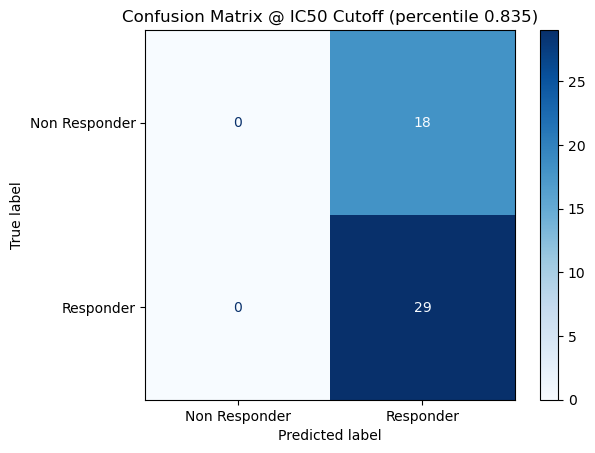

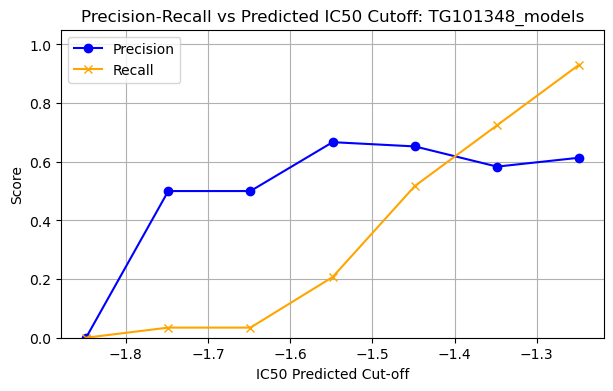


Evaluation for Results/Models_IC50/mlp/TG101348_models
F1 Score: 0.763
Precision: 0.617
Recall: 1.000
    Original Index  Predicted IC50  True Sensitivity
0                2       -1.848347                 1
1               39       -1.810289                 0
2               16       -1.642895                 0
3               28       -1.639856                 1
4                9       -1.618038                 1
5               31       -1.610857                 1
6                3       -1.580999                 0
7                5       -1.565947                 1
8               13       -1.558860                 1
9               33       -1.534483                 1
10              22       -1.530599                 0
11              17       -1.529165                 0
12              30       -1.516077                 1
13              27       -1.505368                 1
14              42       -1.502324                 1
15               8       -1.491924               

In [24]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50/mlp/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=0.835

)

#### CNN

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


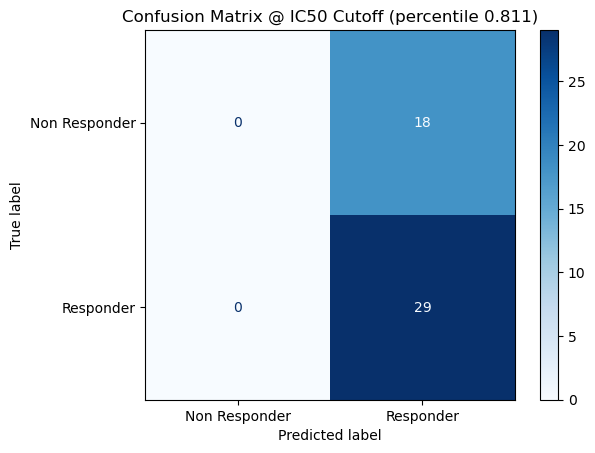

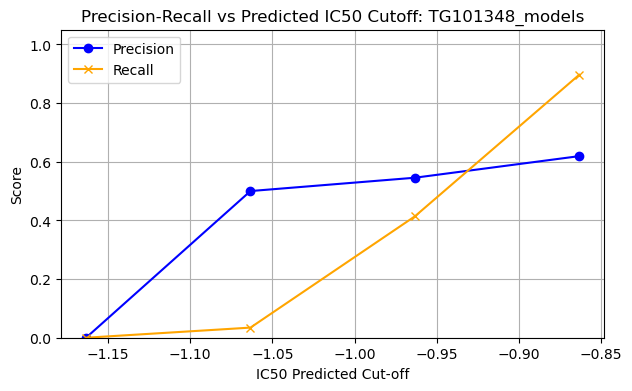


Evaluation for Results/Models_IC50/cnn/TG101348_models
F1 Score: 0.763
Precision: 0.617
Recall: 1.000
    Original Index  Predicted IC50  True Sensitivity
0               28       -1.163380                 1
1               39       -1.102859                 0
2               36       -1.060429                 1
3                1       -1.055709                 0
4                2       -1.052572                 1
5                9       -1.052567                 1
6               31       -1.046663                 1
7               13       -1.041175                 1
8               16       -1.030246                 0
9               33       -1.009130                 1
10              40       -1.005814                 0
11               7       -1.005641                 0
12               4       -1.003932                 1
13              27       -0.999873                 1
14              17       -0.993129                 0
15              24       -0.989076               

In [25]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50/cnn/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=0.811

)

### SMOTE

#### Tree Models

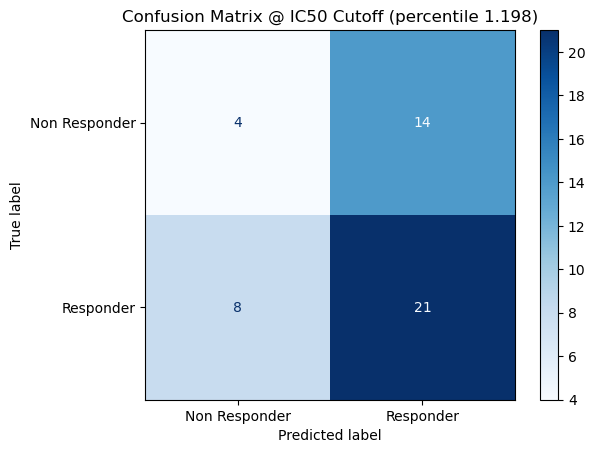

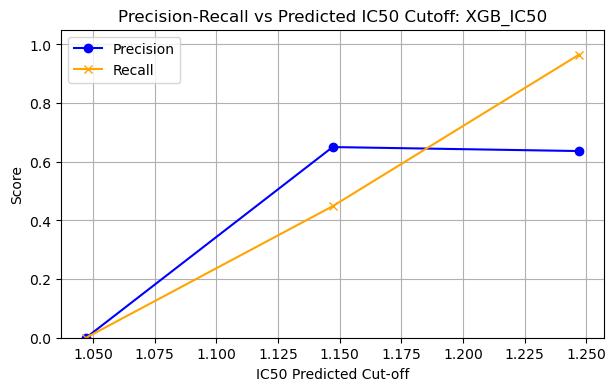


Evaluation for Results/Models_IC50_SMOTE/XGB_IC50
F1 Score: 0.656
Precision: 0.600
Recall: 0.724
    Original Index  Predicted IC50  True Sensitivity
0               38        1.047186                 0
1               25        1.065249                 1
2               42        1.082469                 1
3               31        1.084838                 1
4               23        1.100981                 0
5               12        1.109806                 1
6               20        1.111540                 1
7               44        1.114493                 0
8               29        1.118918                 1
9               11        1.119559                 1
10               8        1.120978                 1
11              16        1.121651                 0
12              43        1.128223                 1
13              10        1.132575                 1
14               6        1.132846                 1
15              40        1.135436                 0
1

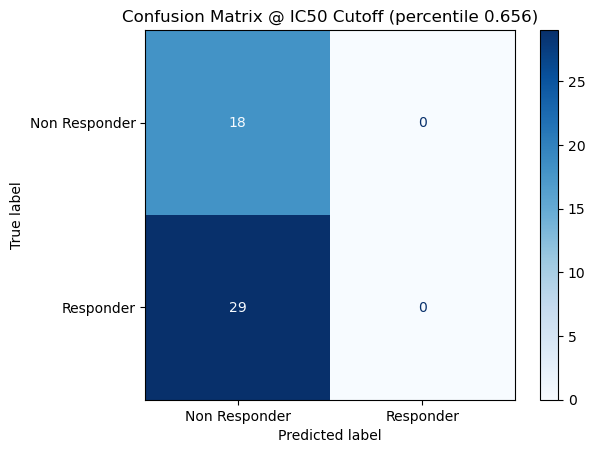

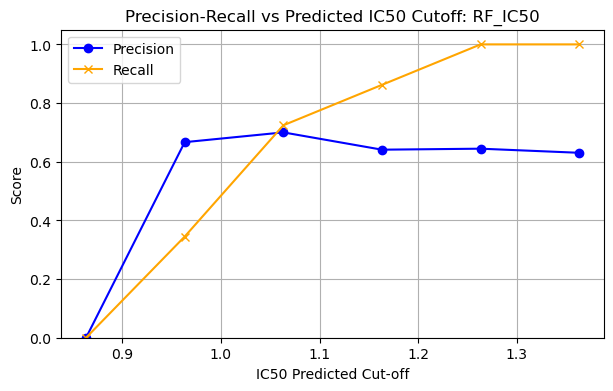


Evaluation for Results/Models_IC50_SMOTE/RF_IC50
F1 Score: 0.000
Precision: 0.000
Recall: 0.000
    Original Index  Predicted IC50  True Sensitivity
0                0        0.863324                 1
1               31        0.864000                 1
2               40        0.871687                 0
3               36        0.880031                 1
4               23        0.888320                 0
5                7        0.889120                 0
6               10        0.891792                 1
7               38        0.910308                 0
8               43        0.925036                 1
9               34        0.927696                 1
10              12        0.947419                 1
11              28        0.952411                 1
12              42        0.953180                 1
13              25        0.960139                 1
14              16        0.960727                 0
15              11        0.964027                 1
16

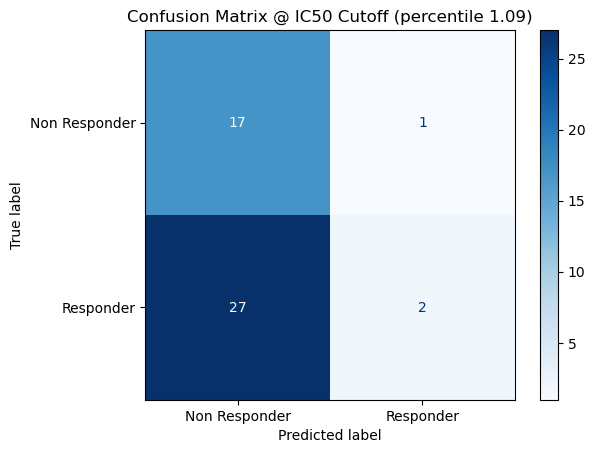

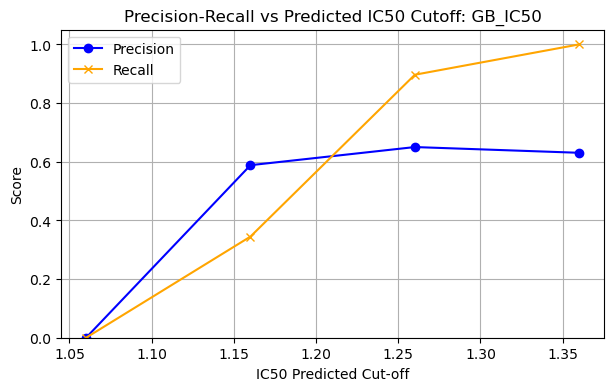


Evaluation for Results/Models_IC50_SMOTE/GB_IC50
F1 Score: 0.125
Precision: 0.667
Recall: 0.069
    Original Index  Predicted IC50  True Sensitivity
0                0        1.060095                 1
1               38        1.067183                 0
2               10        1.081731                 1
3               11        1.100131                 1
4               25        1.101151                 1
5               23        1.103897                 0
6               40        1.106850                 0
7               34        1.107034                 1
8               31        1.109393                 1
9               36        1.112389                 1
10              16        1.122820                 0
11              42        1.126522                 1
12              44        1.129898                 0
13               7        1.141860                 0
14              20        1.142061                 1
15              43        1.142752                 1
16

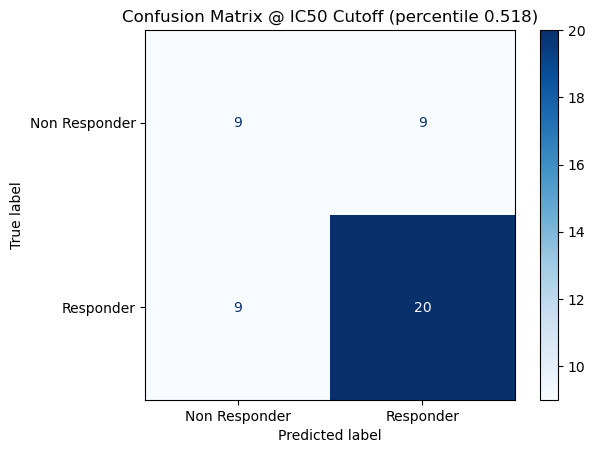

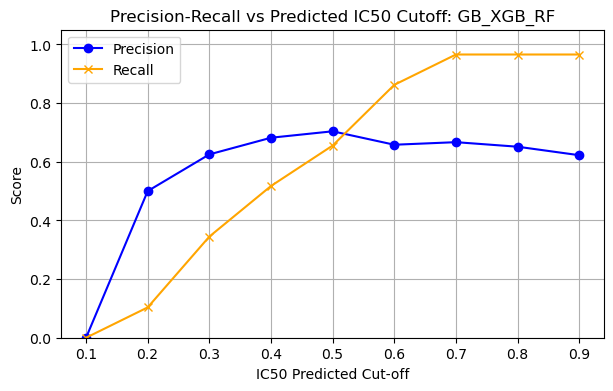


Evaluation for Results/Models_IC50_SMOTE/GB_XGB_RF
F1 Score: 0.690
Precision: 0.690
Recall: 0.690
    Original Index  Predicted IC50  True Sensitivity
0               40        0.100113                 0
1               10        0.110535                 1
2               43        0.158201                 1
3               31        0.168027                 1
4               41        0.181509                 0
5               23        0.187936                 0
6               36        0.201353                 1
7               28        0.202160                 1
8                8        0.222742                 1
9               25        0.226506                 1
10              44        0.227971                 0
11              11        0.237311                 1
12               9        0.265560                 1
13               7        0.281300                 0
14              38        0.285607                 0
15              34        0.295305                 1


In [26]:
drug_models_dirs = [
    "Results/Models_IC50_SMOTE/XGB_IC50",
    "Results/Models_IC50_SMOTE/RF_IC50",
    "Results/Models_IC50_SMOTE/GB_IC50",
    "Results/Models_IC50_SMOTE/GB_XGB_RF"
]
cut = [1.198,0.656,1.090,0.518] 
df_sorted_list = []
for i in range(len(drug_models_dirs)):
    model_dir, cutoff = drug_models_dirs[i],cut[i]
    df_sorted = evaluate_model_directory_ic50(model_dir, df_paz, labels,cutoff = cutoff)
    df_sorted_list.append(df_sorted) 

#### MLP

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


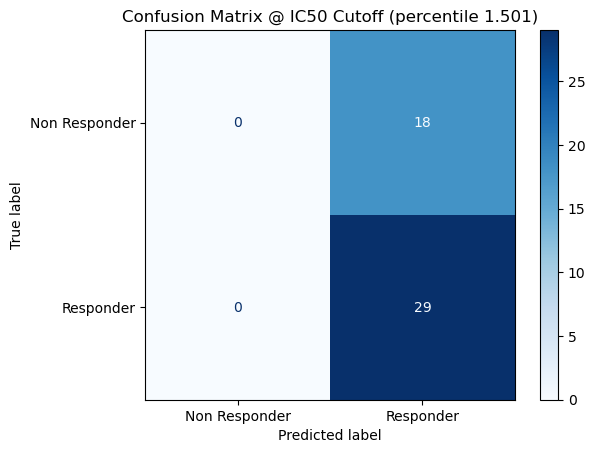

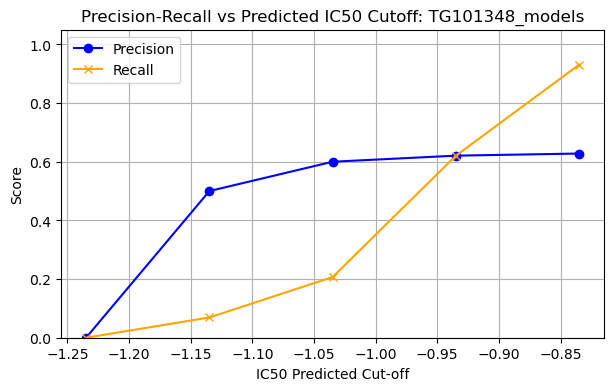


Evaluation for Results/Models_IC50_SMOTE/mlp/TG101348_models
F1 Score: 0.763
Precision: 0.617
Recall: 1.000
    Original Index  Predicted IC50  True Sensitivity
0                9       -1.234843                 1
1                2       -1.221733                 1
2               16       -1.191215                 0
3               39       -1.172550                 0
4               13       -1.108657                 1
5                3       -1.083504                 0
6               31       -1.072850                 1
7               27       -1.054773                 1
8               21       -1.038636                 0
9               28       -1.036103                 1
10               5       -1.033926                 1
11               8       -1.032835                 1
12               0       -1.031327                 1
13               7       -1.009849                 0
14              17       -1.005784                 0
15              36       -1.005287         

In [27]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50_SMOTE/mlp/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=1.501
)


#### CNN

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


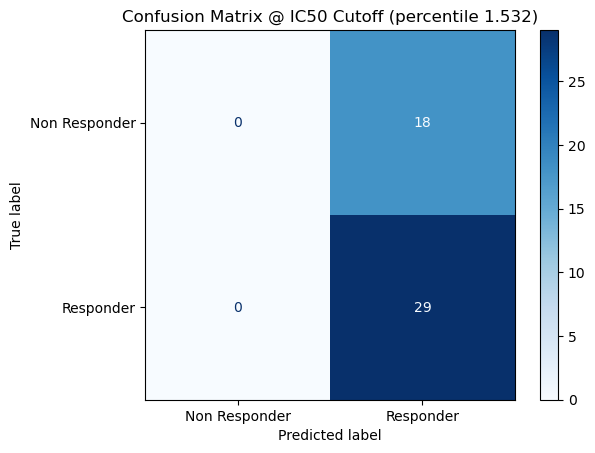

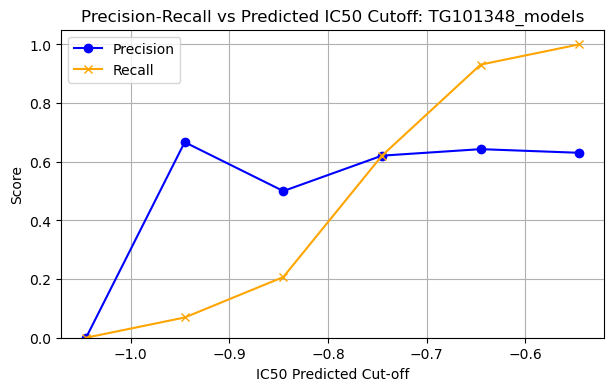


Evaluation for Results/Models_IC50_SMOTE/cnn/TG101348_models
F1 Score: 0.763
Precision: 0.617
Recall: 1.000
    Original Index  Predicted IC50  True Sensitivity
0                9       -1.045239                 1
1               39       -0.992537                 0
2               13       -0.991068                 1
3               28       -0.932328                 1
4               17       -0.893570                 0
5               21       -0.892530                 0
6               33       -0.891139                 1
7               31       -0.889593                 1
8                1       -0.878432                 0
9               27       -0.873217                 1
10              46       -0.871357                 0
11               3       -0.870537                 0
12              38       -0.845207                 0
13               8       -0.831467                 1
14              11       -0.828204                 1
15              16       -0.821048         

In [28]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50_SMOTE/cnn/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=1.532

)
